<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/Memoria_experiment2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m spacy download es_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

from numpy.random import seed
seed(9)

import tensorflow as tf
tf.random.set_seed(9)

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

import nltk
from nltk.tokenize import WordPunctTokenizer
import keras
import re
import string
from collections import Counter

nltk.download("popular")
nltk.download('stopwords')
print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [4]:
df = pd.read_csv("gdrive/My Drive/TFG/overviews_final.csv", sep='#',encoding='utf-8', lineterminator='\n')

In [5]:
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: eval(x))

In [6]:
# Count
ini_n_words = len(Counter(" ".join(df.overview).split()))

In [7]:
# Normalización

def normalize(x):
  x = x.lower()
  replacements = (
      ("á", "a"),
      ("é", "e"),
      ("í", "i"),
      ("ó", "o"),
      ("ú", "u"),
      ("ñ", "n")
  )
  for a, b in replacements:
      x = x.replace(a, b)

  x = x.translate(str.maketrans('','',string.punctuation))
  x = x.translate(str.maketrans('','','ªº¡¿'))   
  x = x.replace("  ", " ") 
  return x

In [8]:
df['overview'] = df['overview'].progress_apply(lambda x: normalize(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [normalize(i) for i in x])

In [9]:
# Count
normalize_n_words = len(Counter(" ".join(df.overview).split()))

In [10]:
# Stop_words

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist()
stop_words = [normalize(word) for word in stop_words]

def delete_stop_words(x):
  words = x.split(' ')
  words = [word for word in words if word not in stop_words]
  x = str(' '.join(words))
  return x

In [11]:
df['overview'] = df['overview'].progress_apply(lambda x: delete_stop_words(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [delete_stop_words(i) for i in x])

In [12]:
# Count
sw_n_words = len(Counter(" ".join(df.overview).split()))

In [13]:
# Lemmatization

import spacy

nlp = spacy.load('es_core_news_sm')

def lemmatize_sentece(sentence):  
  doc = nlp(sentence)
  return ' '.join([word.lemma_ for word in doc])

In [15]:
df_lemma = df.copy()
df_lemma['overview'] = df['overview'].progress_apply(lambda x: lemmatize_sentece(x))
df_lemma['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [lemmatize_sentece(i) for i in x])

In [17]:
# Count
lemma_n_words = len(Counter(" ".join(df_lemma.overview).split()))

In [18]:
# Steaming

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish", ignore_stopwords=True)

def stem_sentence(sentence):
  stemmed_text = [stemmer.stem(word) for word in word_tokenize(sentence)]
  return " ".join(stemmed_text)

In [19]:
df['overview'] = df['overview'].progress_apply(lambda x: stem_sentence(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [20]:
df_lemma['overview'] = df_lemma['overview'].progress_apply(lambda x: stem_sentence(x))
df_lemma['new_overviews'] = df_lemma['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [21]:
# Count
stemming_n_words = len(Counter(" ".join(df.overview).split()))
stemming_lemma_n_words = len(Counter(" ".join(df_lemma.overview).split()))

In [24]:
step = ['Inicio', 'Norm.', 'Stop Words', 'Lemmatization', 'Steamming', 'Stem. + Lemma.']
n_words = [ini_n_words, normalize_n_words, sw_n_words, lemma_n_words, stemming_n_words, stemming_lemma_n_words]

data_count = {
    'Preprocesamiento': step,
    'N palabras': n_words
}

df_count = pd.DataFrame(data=data_count)

In [27]:
n_words

[18990, 13510, 13070, 9821, 8491, 8235]

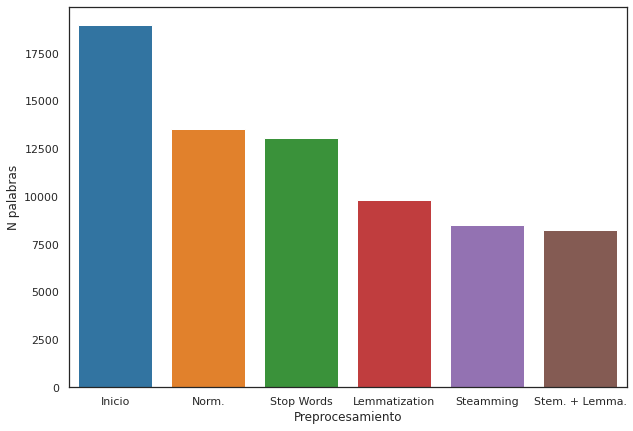

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x="Preprocesamiento", y="N palabras", data=df_count, ax=ax)